In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('/workspace/deep_birth_death/src')

from evaluation.regression import get_regression_metrics, plot_errors_boxplot, plot_errors, predicted_minus_target_vs_target, get_clipping_results

## Generate the results

In [8]:
pd.options.display.float_format = "{:,.4f}".format

In [9]:
n_tips = [674, 489, 87]
div_scenarios = ["BD", "HE", "ME", "SAT", "SR", "WW"]

In [10]:
inference_results = dict()

for tip in n_tips:
    inference_results[tip] = dict()
    for div in div_scenarios:
        
        #Load the data
        inference_results[tip][div] = dict()

        file_path = "/workspace/deep_birth_death/MLE/inference_data/" + str(tip) + "/TreePar_inference_" + str(tip) + "_" + div + ".csv"
        if div == "SAT":
            file_path = "/workspace/deep_birth_death/MLE/inference_data/" + str(tip) + "/DDD_inference_" + str(tip) + "_" + div + ".csv"
        df = pd.read_csv(file_path)
        
        if div == "BD":
            y_test = df[["real_a0", "real_r0"]].to_numpy()
            y_pred_raw = df[["estimated_a", "estimated_r"]].to_numpy()
            
            min_value = np.array([0.01, 0.01])            
            max_value = np.array([0.5, 4])                        
            
        elif div == "HE":
            y_test = df[["real_a0", "real_r0"]].to_numpy()
            y_pred_raw = df[["estimated_a", "estimated_r"]].to_numpy()
            
            min_value = np.array([0.8, 0.01])            
            max_value = np.array([0.9, 4])   
                        
        elif div == "SAT":
            y_test = df[["real_lambda"]].to_numpy()
            y_pred_raw = df[["estimated_lambda"]].to_numpy()
            
            min_value = np.array([0.01])            
            max_value = np.array([4])  
  
            
        elif div == "ME":
            y_test = df[["real_a0", "real_r0", "real_frac_1", "real_t"]].to_numpy()
            y_pred_raw = df[["estimated_a_me", "estimated_r_me", "estimated_frac_1_me", "estimated_time_me"]].to_numpy()
          
            min_value = np.array([0.3, 0.01, 0.1, 3])            
            max_value = np.array([0.8, 1, 0.3, 20]) 
        
        elif div == "SR":
            y_test = df[["real_a0", "real_a1","real_r0", "real_r1", "real_t"]].to_numpy()
            y_pred_raw = df[["estimated_a0", "estimated_a1", "estimated_r0", "estimated_r1", "estimated_t"]].to_numpy()
        
            min_value = np.array([0.05, 0.55, 0.25, 0.01, 3])            
            max_value = np.array([0.5, 0.95, 1.99, 1, 20])         
        
        else: 
            y_test = df[["real_a0", "real_a1","real_r0", "real_r1", "real_t"]].to_numpy()
            y_pred_raw = df[["estimated_a0", "estimated_a1", "estimated_r0", "estimated_r1",    "estimated_t"]].to_numpy()
            
            min_value = np.array([1.3, 0.25, -0.2, 0.5, 3])            
            max_value = np.array([2, 0.6, -0.01, 1.5, 20])              
      
        
        #Clip the values
        y_pred = np.clip(y_pred_raw, min_value, max_value)
        precentage_clipped = (np.sum(y_pred_raw != y_pred, axis=0)/y_pred_raw.shape[0])*100
        
        clipped_below = (np.sum(y_pred_raw < min_value, axis=0) / y_pred_raw.shape[0]) * 100
        clipped_above = (np.sum(y_pred_raw > max_value, axis=0) / y_pred_raw.shape[0]) * 100

            
        #Estimate the erros
        mae = np.mean(np.abs(y_pred - y_test), axis=0)
        mre = np.mean(np.abs((y_pred - y_test) / y_test), axis=0)
        
        raw_error = y_pred - y_test
        abs_error = abs(y_pred - y_test)
        
        #Save the results
        inference_results[tip][div]["MAE"] = mae
        inference_results[tip][div]["MRE"] = mre       
        inference_results[tip][div]["raw_error"] = raw_error
        inference_results[tip][div]["abs_error"] = abs_error   
        
        inference_results[tip][div]["clipped_perc"] = precentage_clipped
        inference_results[tip][div]["clipped_below"] = clipped_below        
        inference_results[tip][div]["clipped_above"] = clipped_above   
        
        inference_results[tip][div]["real_values"] = y_test  

## Get regression metrics

### MAE 

In [11]:
for tip in n_tips: 
    print("----------- Size is " + str(tip) + " -----------\n")
    for scenario in div_scenarios: 
        print("-----------Div_scenario is " + scenario +" -----------")
        mae = get_regression_metrics(inference_results, tip, scenario, "MAE")
        print(mae, "\n")

----------- Size is 674 -----------

-----------Div_scenario is BD -----------
         r      a
MAE 0.0688 0.1166 

-----------Div_scenario is HE -----------
         r      a
MAE 0.0191 0.2462 

-----------Div_scenario is ME -----------
         r      a   time   frac
MAE 0.0574 0.0338 0.0584 0.9089 

-----------Div_scenario is SAT -----------
     lambda 0
MAE    0.0631 

-----------Div_scenario is SR -----------
        r0     r1     a0     a1   time
MAE 0.0965 0.2397 0.0563 0.0276 1.4319 

-----------Div_scenario is WW -----------
        r0     r1     a0     a1   time
MAE 0.2117 0.1621 0.0351 0.1407 0.3356 

----------- Size is 489 -----------

-----------Div_scenario is BD -----------
         r      a
MAE 0.0805 0.1510 

-----------Div_scenario is HE -----------
         r      a
MAE 0.0260 0.2678 

-----------Div_scenario is ME -----------
         r      a   time   frac
MAE 0.0580 0.0264 0.0543 0.7131 

-----------Div_scenario is SAT -----------
     lambda 0
MAE    0.0700 



### MRE 

In [12]:
for tip in n_tips: 
    print("----------- Size is " + str(tip) + " -----------\n")
    for scenario in div_scenarios: 
        print("-----------Div_scenario is " + scenario +" -----------")
        mre = get_regression_metrics(inference_results, tip, scenario, "MRE")
        print(mre, "\n")

----------- Size is 674 -----------

-----------Div_scenario is BD -----------
         r      a
MRE 0.4991 0.0583 

-----------Div_scenario is HE -----------
         r      a
MRE 0.0225 0.1247 

-----------Div_scenario is ME -----------
         r      a   time   frac
MRE 0.1251 0.1016 0.2870 0.0936 

-----------Div_scenario is SAT -----------
     lambda 0
MRE    0.0343 

-----------Div_scenario is SR -----------
        r0     r1     a0     a1   time
MRE 0.4226 0.3486 0.0930 0.7839 0.1600 

-----------Div_scenario is WW -----------
        r0     r1     a0     a1   time
MRE 0.1220 0.3624 0.4966 0.1417 0.0281 

----------- Size is 489 -----------

-----------Div_scenario is BD -----------
         r      a
MRE 0.7354 0.0745 

-----------Div_scenario is HE -----------
         r      a
MRE 0.0308 0.1648 

-----------Div_scenario is ME -----------
         r      a   time   frac
MRE 0.1224 0.0905 0.2582 0.0776 

-----------Div_scenario is SAT -----------
     lambda 0
MRE    0.0341 



### Clipping percentage

In [13]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for div in div_scenarios:
        print(f"--- {div} ---")
        df_tot, df_below, df_above = get_clipping_results(inference_results, tip, div)
        print(df_tot)
        print(df_below)
        print(df_above, "\n")


----------- Size is 674 -----------
--- BD ---
                a      r
Clipped % 17.0000 1.0000
             a      r
Below % 9.0000 0.0000
             a      r
Above % 8.0000 1.0000 

--- HE ---
                a      r
Clipped % 21.0000 5.0000
             a      r
Below % 7.0000 0.0000
              a      r
Above % 14.0000 5.0000 

--- ME ---
                a      r    frac   time
Clipped % 16.0000 0.0000 30.0000 5.0000
              a      r    frac   time
Below % 13.0000 0.0000 24.0000 2.0000
             a      r   frac   time
Above % 3.0000 0.0000 6.0000 3.0000 

--- SAT ---
           lambda 0
Clipped %    3.0000
         lambda 0
Below %    1.0000
         lambda 0
Above %    2.0000 

--- SR ---
               a0      a1     r0      r1   time
Clipped % 33.3333 83.3333 0.0000 58.3333 0.0000
             a0      a1     r0      r1   time
Below % 33.3333 25.0000 0.0000 58.3333 0.0000
            a0      a1     r0     r1   time
Above % 0.0000 58.3333 0.0000 0.0000 0.0000 

---

### Errors boxplots 


----------- Size is 674 -----------


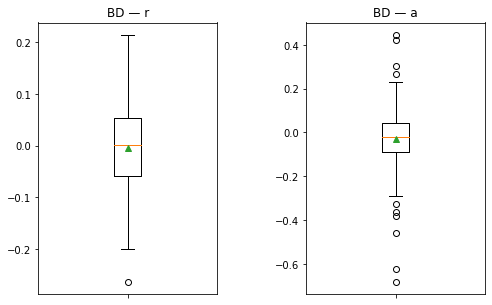

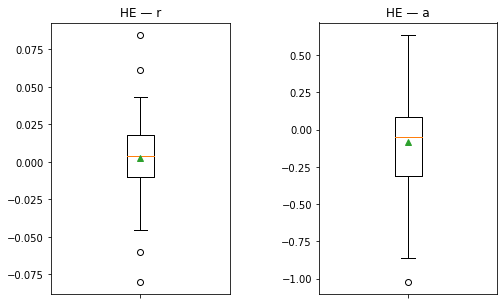

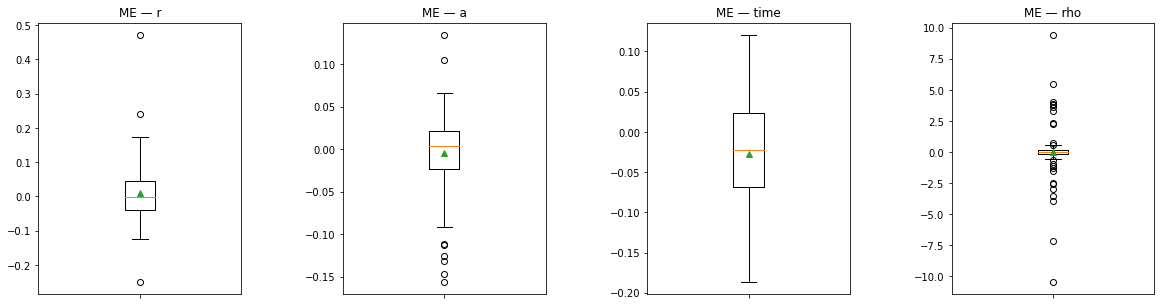

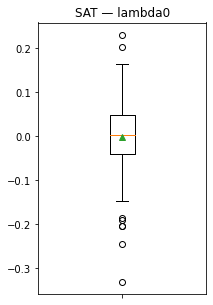

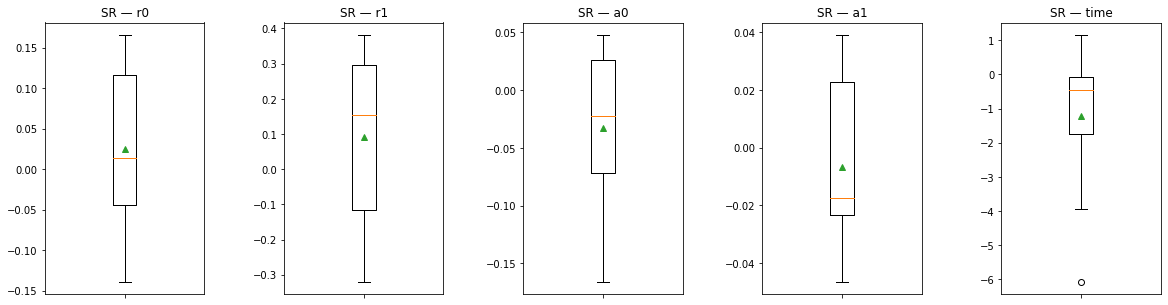

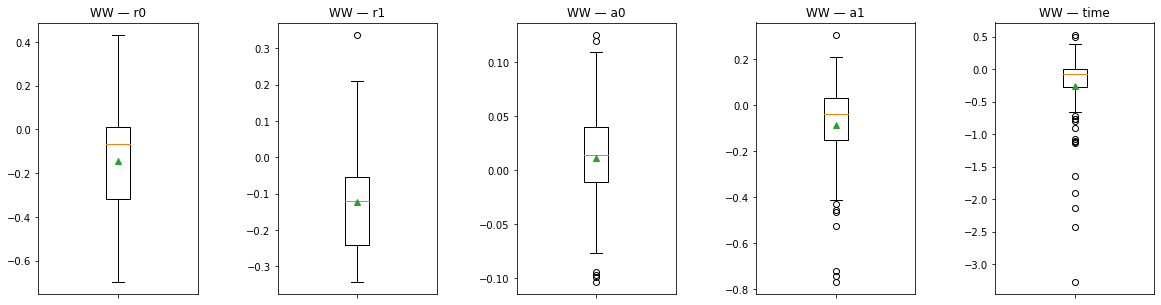


----------- Size is 489 -----------


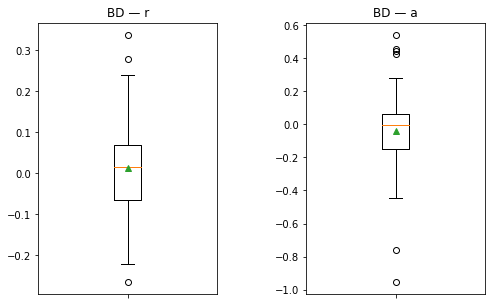

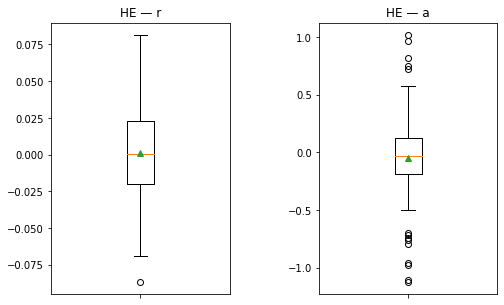

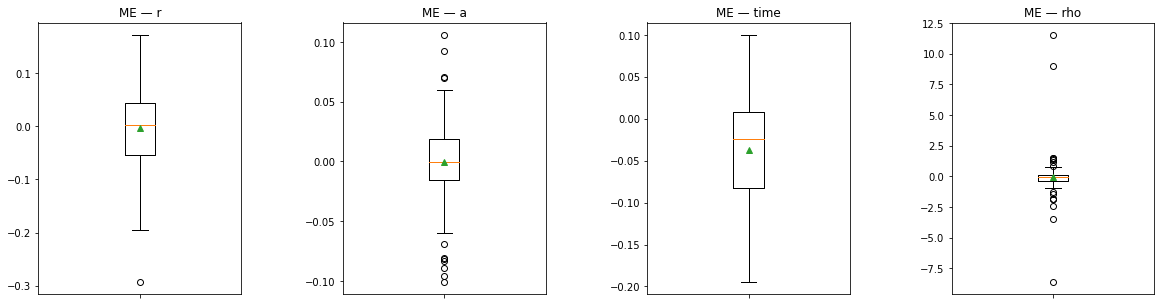

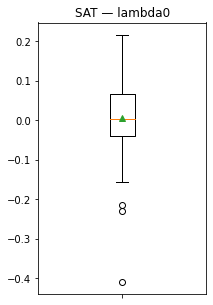

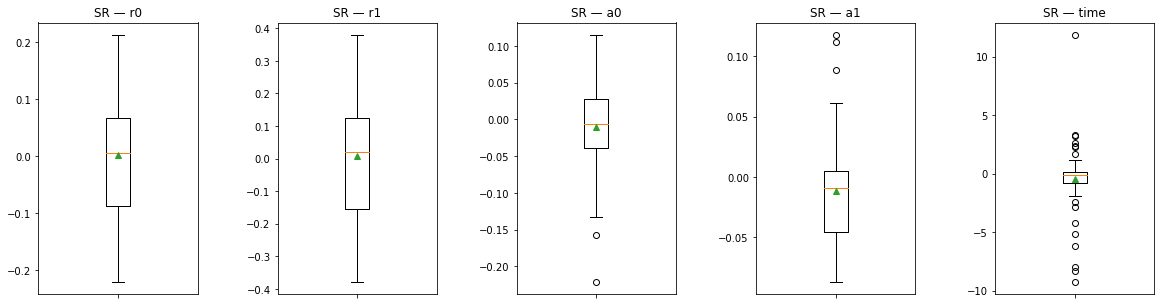

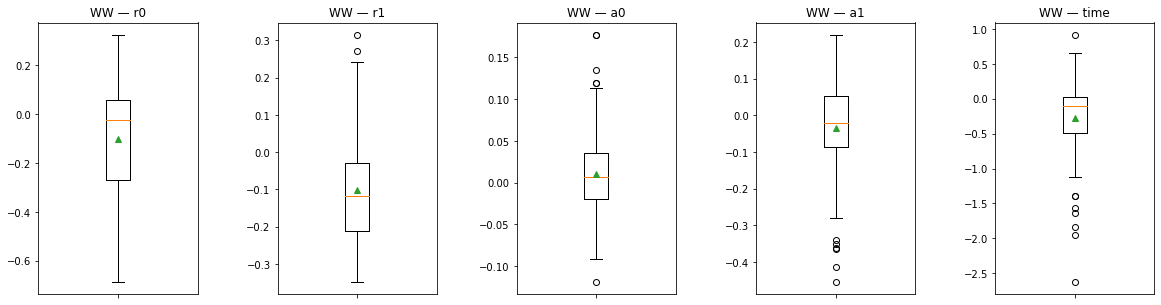


----------- Size is 87 -----------


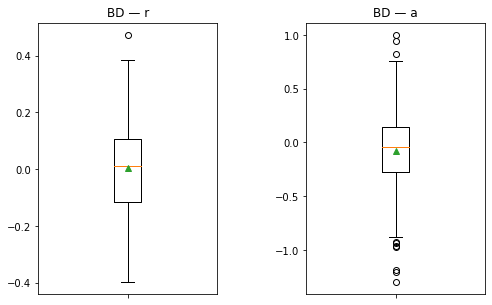

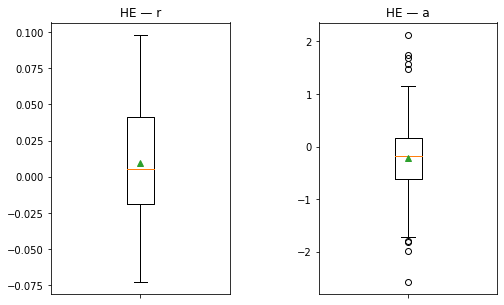

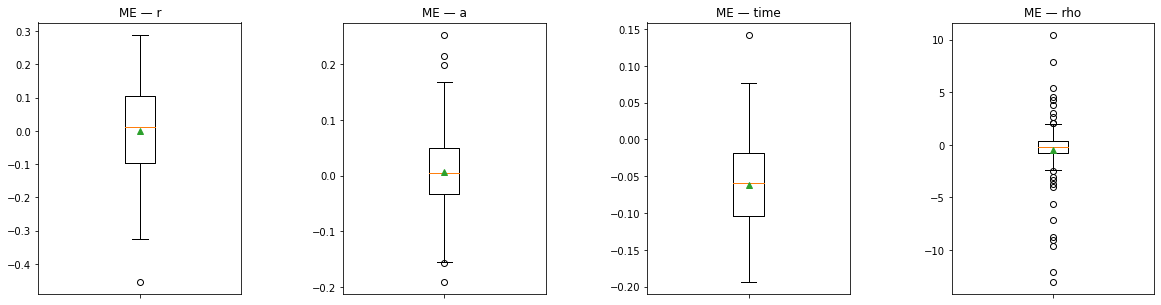

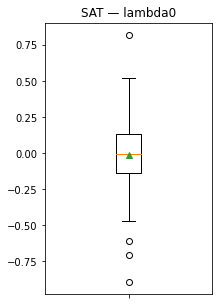

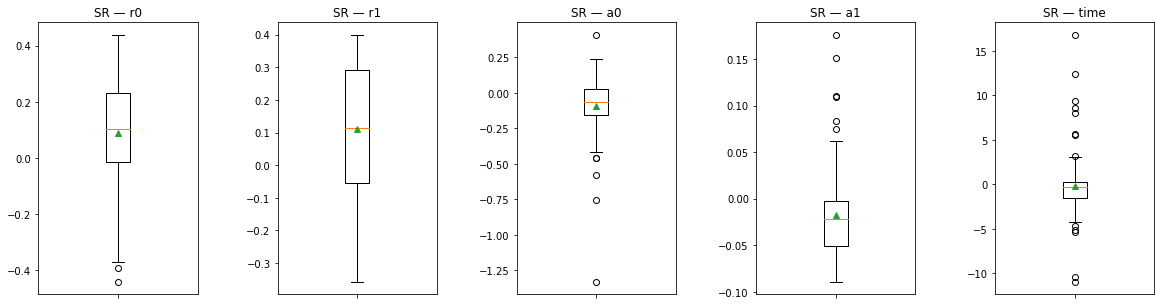

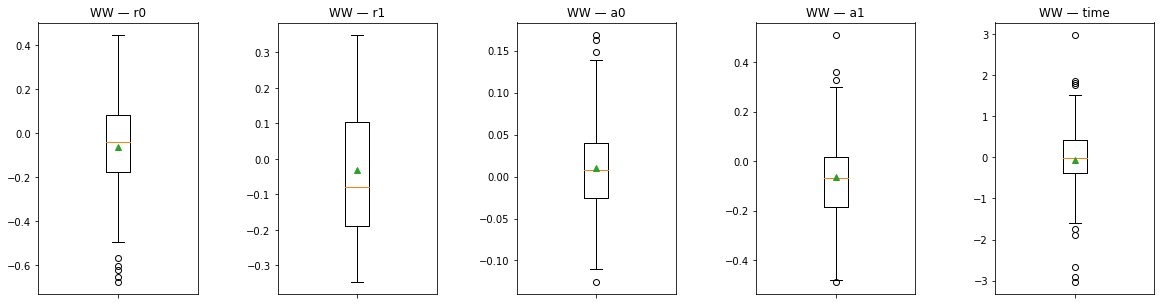

In [14]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for scenario in div_scenarios:
        plot_errors_boxplot(inference_results, tip, scenario)       

### Errors swarmplots 


----------- Size is 674 -----------


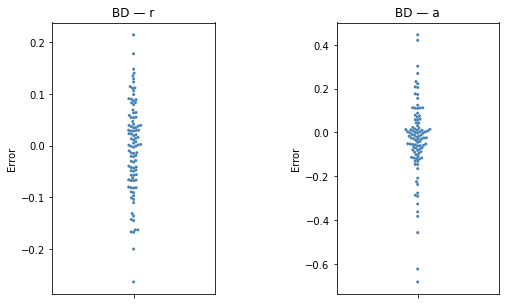

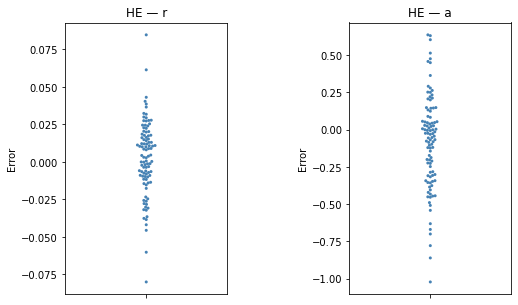

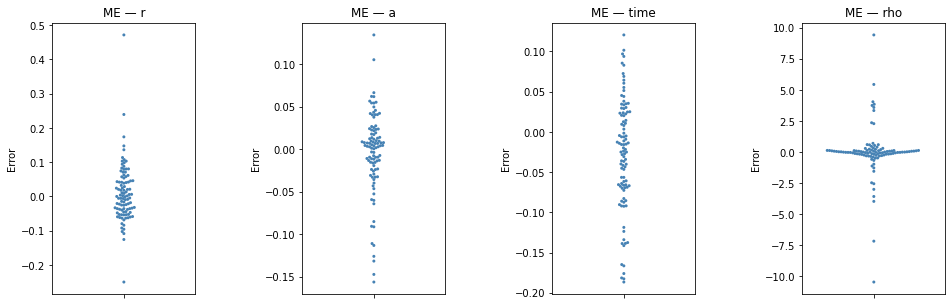

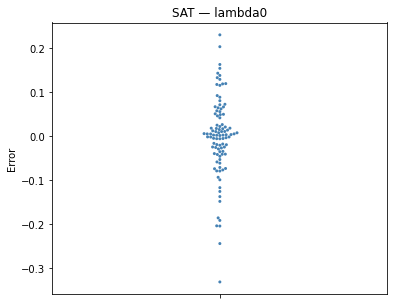

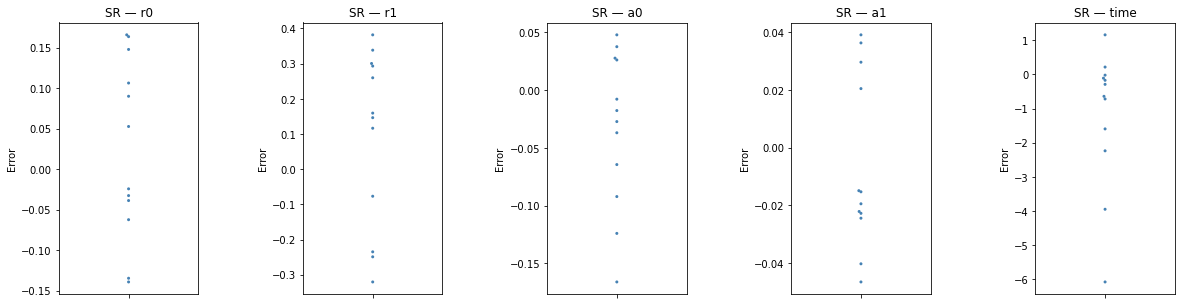

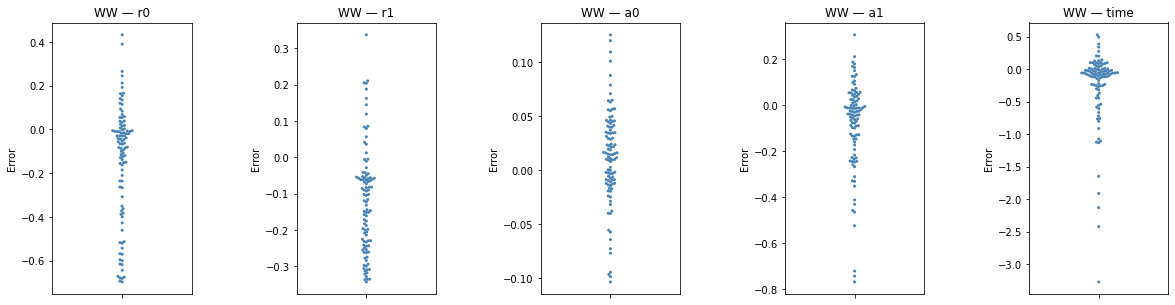


----------- Size is 489 -----------


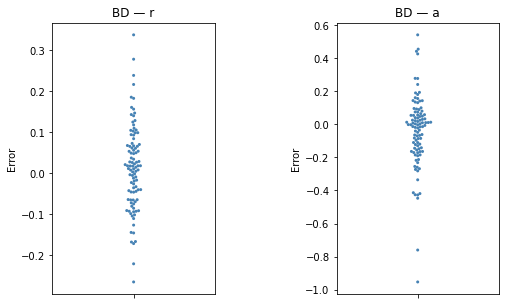

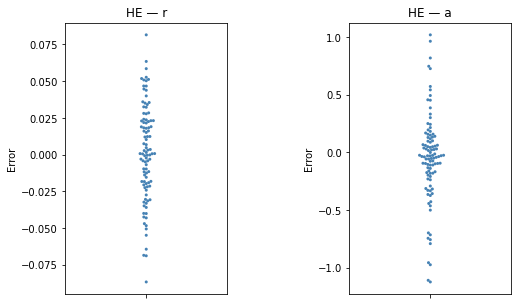

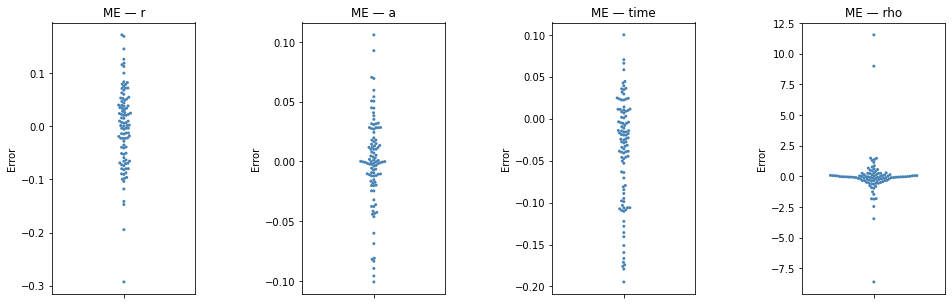

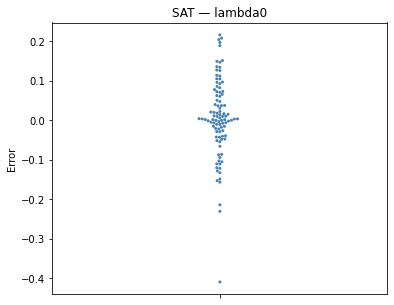

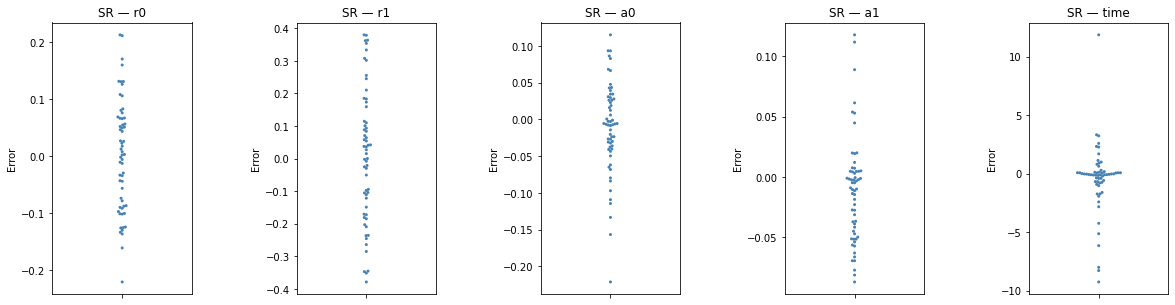

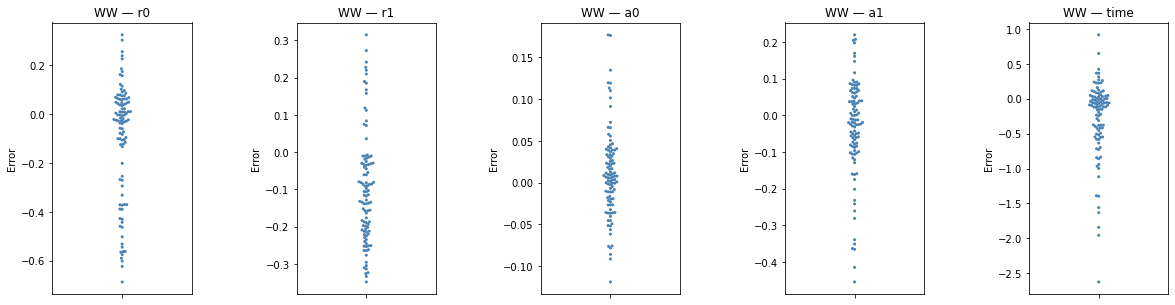


----------- Size is 87 -----------


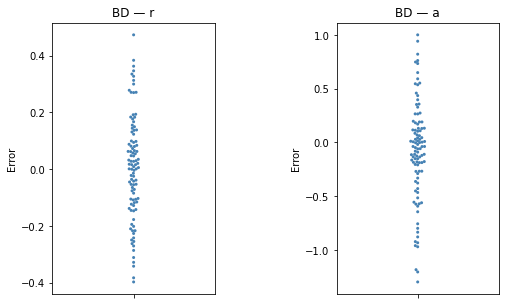

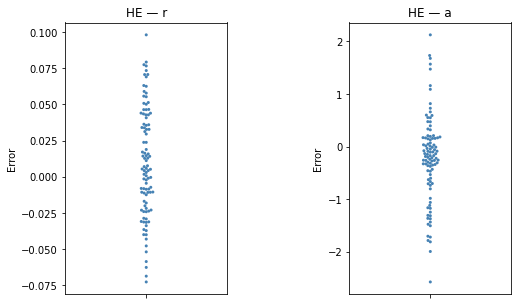

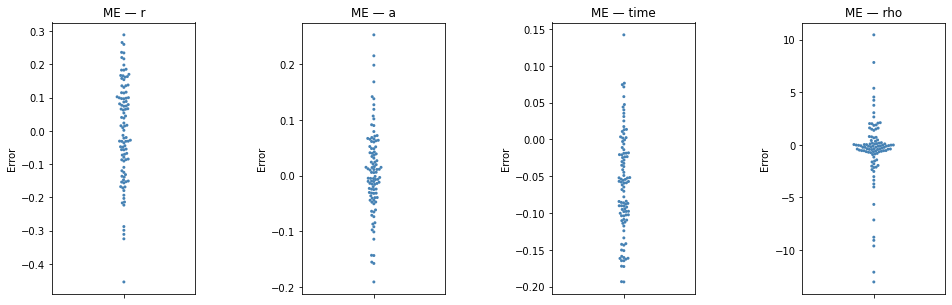

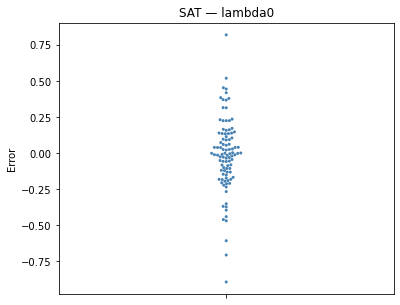

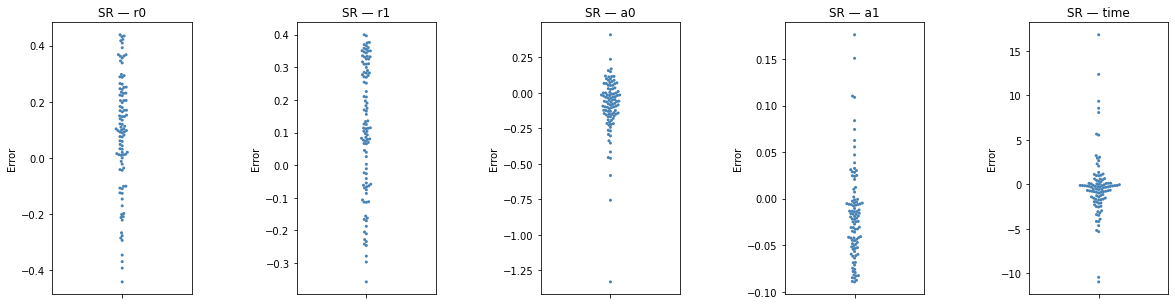

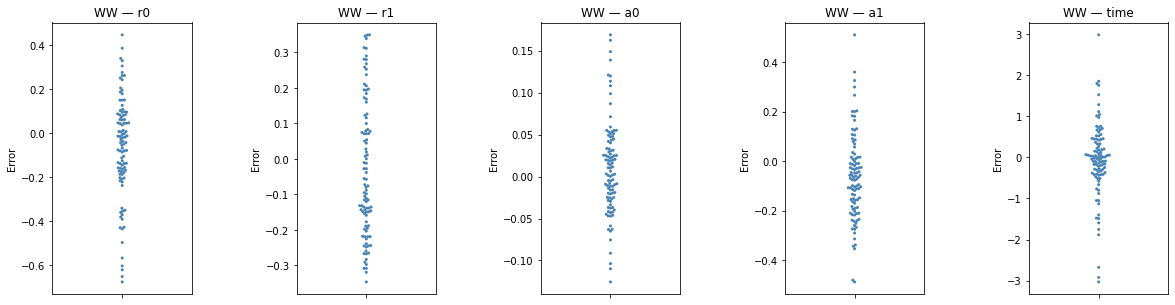

In [15]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for scenario in div_scenarios:
        plot_errors(inference_results, tip, scenario)      

### Absolute errors vs target

In [ ]:
for tip in n_tips:
    for scenario in div_scenarios:
        predicted_minus_target_vs_target(inference_results, tip, scenario)    